## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

In [3]:
#asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+12)
#print(asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'].describe())
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
test_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2007')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index < '01-01-2018'))
train_yrs = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index < '01-01-2017')

print(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Temp_degC'].describe())

count    8710.000000
mean       -0.001883
std         8.559429
min       -30.600000
25%        -6.270000
50%         0.000000
75%         7.300000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    1406.000000
mean        0.683570
std         8.122622
min       -28.100000
25%        -4.875000
50%         0.600000
75%         7.500000
max        18.300000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    7304.000000
mean       -0.133831
std         8.635270
min       -30.600000
25%        -6.470000
50%        -0.100000
75%         7.225000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64


***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Surface Variable OLS (no filtering)


In [5]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df[train_yrs]).fit()
OLS_LXV_12hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_12hr_delta_Pressure_hp', asos_snotel_UA_df[train_yrs]).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df[train_yrs]).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_12hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.007
Model:                                               OLS   Adj. R-squared:                  0.002
Method:                                    Least Squares   F-statistic:                     1.425
Date:                                   Sat, 20 Apr 2019   Prob (F-statistic):              0.234
Time:                                           11:37:42   Log-Likelihood:                -441.11
No. Observations:                                    210   AIC:                             886.2
Df Residuals:                                        208   BIC:                             892.9
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Run OLS model with all surface variables only (no filtering)

In [6]:
#'CMtn_1hr_Precipitation_mm', 'CMtn_6hr_Precipitation_mm'


variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']
from collections import OrderedDict

variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df[train_yrs]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df[train_yrs]).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']
******
LXV_12hr_delta_Pressure_hp
CMtn_WindSpeed_mps+ LXV_12hr_delta_Pressure_hp
CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ LXV_12hr_delta_Pressure_hp
CMtn_WindDirection_deg+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ LXV_12hr_delta_Pressure_hp
LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ LXV_12hr_delta_Pressure_hp
LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ LXV_12hr_delta_Pressure_hp
CMtn_Temperature_degC+ LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ LXV_12hr_delta_Pressure_hp
LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_WindSpeed_mps+

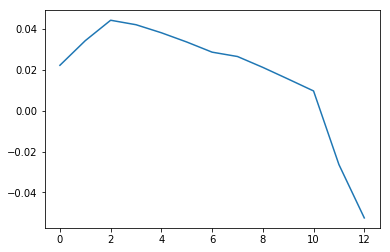

In [7]:
plt.plot(adjRs)

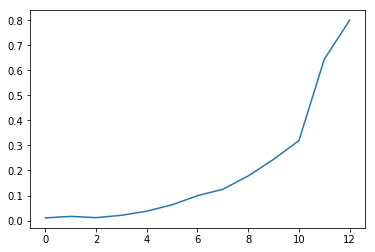

In [8]:
plt.plot(f_pvalues)

## Run OLS model with surface variables only (high data capture, filtered by UA)
**We only want to use features with high data capture in the training years**

In [9]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
    total_poss = len(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df[all_yrs][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

**Because we will want an apples to apples type comparision with the OLS model we perform with Surface+UA data, we must be sure sure to use the same snowfall data. **For every snowfall amount used, there must be a datapoint for every corresponding surface and upper air data features.  Therefore, any rows with an NaN value will be removed from the analysis.

In [10]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


#df_sfc = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                           'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()
#
#df = asos_snotel_UA_df[df = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                        'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', \
#                        'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', \
#                        'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', \
#                        'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
#                        'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', \
#                        'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', \
#                        'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
#                        'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', \
#                         'KGJT_d250_200_speed_kts','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()

good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()
#test_df = asos_snotel_UA_df[good_vars_snf][test_yrs].dropna()
#train_df = asos_snotel_UA_df[good_vars_snf][train_yrs].dropna()

#print(test_df.describe())
#print(train_df.describe())
#print(filtered_asos_snotel_UA_df[train_yrs].dropna().describe())
print(asos_snotel_UA_df[good_vars_snf] ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2014'].describe())

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

In [11]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
test_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2007')) | ((test_train_df.index >= '01-01-2017') & (test_train_df.index< '01-01-2018'))
train_yrs_tt = (test_train_df.index >= '01-01-2007') & (test_train_df.index < '01-01-2017')

from tabulate import tabulate
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', all_yrs_tt, test_yrs_tt, train_yrs_tt]
counts = []
means = []
maxes = []
sd_missings =[]
std_devs=[]
medians = []

for year in years:


    counts.append(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].count())
    maxes.append((round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].max(),1)))
    means.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].mean(),1))
    medians.append(round(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].median(),1))
    #sd_missings.append(round(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count()/len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year][idx])/12*100,2))
    std_devs.append(round(np.std(test_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][year].dropna()),2))
    #print(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year].count(),len(filtered_asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'][year])/12)
        
tbl = zip(years, counts, means, medians, maxes,std_devs )  
    
print(tabulate(tbl, headers=['Year', 'Number 12hr Snowfall Events >=3', 'Mean', 'Median','Max',  'Std Deviation'], tablefmt='github'))
print(medians)

| Year   |   Number 12hr Snowfall Events >=3 |   Mean |   Median |   Max |   Std Deviation |
|--------|-----------------------------------|--------|----------|-------|-----------------|
| 2006   |                                21 |    5   |      5   |  11   |            2.05 |
| 2007   |                                23 |    3.9 |      3.3 |   6.5 |            1.18 |
| 2008   |                                25 |    4.3 |      3.3 |   8   |            1.84 |
| 2009   |                                16 |    3.9 |      3.8 |   6   |            0.87 |
| 2010   |                                20 |    4.4 |      3.8 |   9   |            1.77 |
| 2011   |                                 0 |  nan   |    nan   | nan   |          nan    |
| 2012   |                                 5 |    6.4 |      8   |  10   |            2.87 |
| 2013   |                                23 |    4.4 |      4   |  12   |            1.94 |
| 2014   |                                37 |    5.7 |      5   |  14

### Run model with good SURFACE variables

In [12]:
from collections import OrderedDict

variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', \
'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', \
'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']
******
CMtn_WindSpeed_mps
CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
CMtn_Temperature_degC+ LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressu

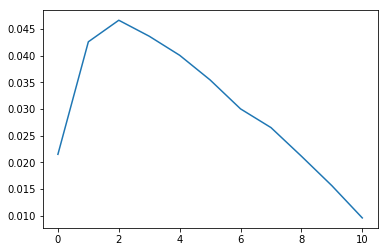

In [13]:
plt.plot(adjRs)

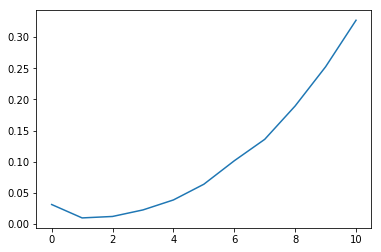

In [14]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [15]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 CMtn_WindSpeed_mps 
 Adjusted R: 0.021514015638045225  Fstat(prob): 0.031288789283694544

1 CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 
 Adjusted R: 0.042571365305989484  Fstat(prob): 0.009787480793376569

2 LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 
 Adjusted R: 0.046603851980261846  Fstat(prob): 0.012121182930896127

3 CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 
 Adjusted R: 0.043614134869658594  Fstat(prob): 0.02262664988010921

4 LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 
 Adjusted R: 0.040045945679467954  Fstat(prob): 0.038630663647111756

5 LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 
 Adjusted R: 0.03543437125264959  Fstat(prob): 0.063873239100339

6 CMtn_Temperature_degC+ LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_h

**Find max adj R and obtain OLS summary**

In [16]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps


In [17]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , asos_snotel_UA_df[train_yrs]).fit() 
print(maxOLS_all.summary())


LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.060
Model:                                               OLS   Adj. R-squared:                  0.044
Method:                                    Least Squares   F-statistic:                     3.765
Date:                                   Sat, 20 Apr 2019   Prob (F-statistic):             0.0118
Time:                                           11:37:56   Log-Likelihood:                -371.85
No. Observations:                                    180   AIC:                             751.7
Df Residuals:                                        176   BIC:                             764.5
Df Model:                                              3                                         
Covariance Type:                               nonr

**Print QQ plot**

Text(0.5,1,'Theoretical vs Sample Quantiles of Residuals')

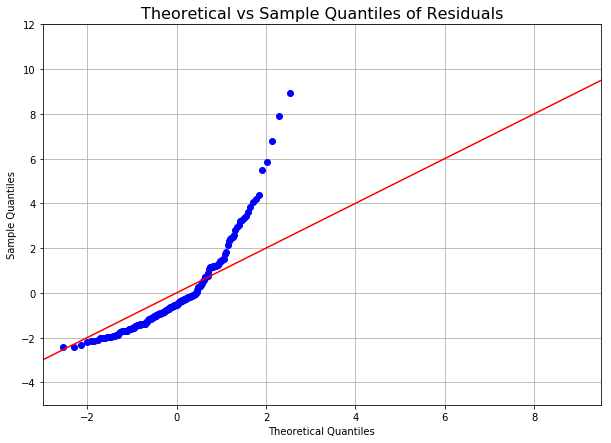

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot(maxOLS_all.resid, line='45', ax = ax)
plt.ylim([-5,12])
plt.grid(True)

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/qq_resid_SFC_5c.png',bbox_inches='tight')
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)

Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results using adjusted R squared as a metric**

In [19]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, asos_snotel_UA_df[train_yrs]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, asos_snotel_UA_df[train_yrs]).fit() 
print(maxOLS_goodp.summary())


LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
1
LXV_12hr_delta_Pressure_hp 0.022236455335143734 0.01
0.022236455335143734 0.01
2
LXV_12hr_delta_Pressure_hp 0.022236455335143734 0.02
3
LXV_12hr_delta_Pressure_hp 0.022236455335143734 0.03
4
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps 0.034295356135126354 0.04
0.034295356135126354 0.04
5
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps 0.034295356135126354 0.05
6
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps 0.034295356135126354 0.06
7
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps 0.034295356135126354 0.07
8
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps 0.034295356135126354 0.08
9
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps 0.034295356135126354 0.09
10
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.1
0.04429241266469863 0.1
11
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.11
12
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CM

LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.92
93
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.93
94
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.9400000000000001
95
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.9500000000000001
96
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.96
97
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.97
98
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.98
99
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps 0.04429241266469863 0.99

 best threshold is:0.1
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0

In [27]:
import csv
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict_snf = maxOLS_goodp.predict(test_train_df[test_yrs_tt][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])

rows = zip(actual_snf, predict_snf)

with open('C:/Users/RAPP/Documents/Capstone/Projects/OLS_SFC_0617Train.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

**So it looks like the best P|t| threshold for variable elimination is 0.27.  A small improvement to adjusted R squared was made**